# Reddit

In [78]:
import pandas as pd
import numpy as np
import datetime
from datetime import datetime

In [79]:
input_format = '%d/%m/%Y %H:%M'
output_format = '%Y-%m-%d %H:%M'
reddit_data=pd.read_csv('./data/Reddit/Reddit.csv')
reddit_data['datetime']=reddit_data['datetime'].apply(lambda x:datetime.strptime(x, input_format).strftime(output_format) )

In [80]:
reddit_data

,upvote_ratio,score,total_awards_received,num_comments,selftext,datetime
0,0.33,0,0,14,"I recently caught a red herring, and you can d...",2022-01-01 00:00
1,0.24,0,0,22,I noticed that almost everyone in the crypto c...,2022-01-01 00:00
2,1.00,13,0,41,My records show I still had some BCHA on my Me...,2022-01-01 02:00
3,0.73,24,0,188,Merry Christmas and a Happy New Year. \n\nPS: ...,2022-01-01 05:00
4,0.33,0,0,7,If you look at Bitcoin satoshies! There's $2....,2022-01-01 07:00
...,...,...,...,...,...,...
31113,0.50,0,0,2,Here's the resource if y'all want to check it ...,2022-06-30 21:00
31114,0.85,267,0,176,\> [BlockFi previously had a valuation of 4 bi...,2022-06-30 21:00
31115,0.78,5,0,40,"If you plan on never selling (and I mean it), ...",2022-06-30 22:00
31116,0.71,3,0,31,Was talking to a friend today trying to get hi...,2022-06-30 22:00


In [81]:
reddit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31118 entries, 0 to 31117
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   upvote_ratio           31118 non-null  float64
 1   score                  31118 non-null  int64  
 2   total_awards_received  31118 non-null  int64  
 3   num_comments           31118 non-null  int64  
 4   selftext               31118 non-null  object 
 5   datetime               31118 non-null  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 1.4+ MB


In [82]:
reddit_data.describe()

,upvote_ratio,score,total_awards_received,num_comments
count,31118.000000,31118.000000,31118.000000,31118.000000
mean,0.657841,73.171990,0.921042,76.882801
std,0.190489,396.039295,4.457744,315.262789
min,0.040000,0.000000,0.000000,0.000000
25%,0.530000,1.000000,0.000000,10.000000
50%,0.670000,4.000000,0.000000,22.000000
75%,0.800000,18.000000,0.000000,51.000000
max,1.000000,14452.000000,193.000000,19169.000000


In [83]:
reddit_data[reddit_data['total_awards_received']==193]

,upvote_ratio,score,total_awards_received,num_comments,selftext,datetime
9338,0.93,5373,193,812,*I posted this yesterday but it was removed by...,2022-02-08 06:00


## Clean the Text

In [84]:
import sys
import regex as re
from nltk.corpus import stopwords
import string
from string import digits
import nltk
import contractions
import json

from nltk import word_tokenize
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yujiewang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [85]:
file_path = './data/abbreviations.json'

with open(file_path, 'r') as json_file:
    json_data = json.load(json_file)
    abbreviations = json_data['abbreviations']

In [86]:
nltk.download('wordnet')
lemma_sents = []
def lemma(text):
    lemmatizer = nltk.WordNetLemmatizer()
    lemma_sent=[lemmatizer.lemmatize(word) for word in text]
    lemma_text=' '.join(lemma_sent)
    return lemma_text

nltk.download('punkt')
def remove_url(text):
    # removal of urls
    url=re.compile(r'https?://\S+|www\.\S+')
    text=url.sub(r'',text)
    # removal of html tags
    html=re.compile('<.*?>')
    text=html.sub(r'',text)
    return text

def convert_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word

def convert_abbrev_in_text(text):
    tokens = word_tokenize(text)
    tokens=[convert_abbrev(word) for word in tokens]
    text = ' '.join(tokens)
    return text

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/yujiewang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/yujiewang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [87]:
#Clean the text
reddit_data['text_clean'] = reddit_data['selftext'].map(remove_url)

In [88]:
def text_clean(text):
    # # Expand contractions
    try:
        text = " ".join([contractions.fix(word) for word in str(text).split()])
    except:
        print(text)
    # # Handle slang and/or acroyms
    text = convert_abbrev_in_text(text)

    # # Remove ticker symbols
    ticker_pattern = r'\$\w+'
    text = re.sub(ticker_pattern, '', text)

    # removal of puctuation
    text=text.translate(str.maketrans('','',string.punctuation))
    # removal of digits
    text=text.translate(str.maketrans('', '', digits))
    # removal of whitespace
    text=" ".join(text.split())

    # Tokenization
    text = nltk.word_tokenize(text)

    # Wordnet lemmatization
    text = lemma(text)

    # removal of stopwords
    stopword=stopwords.words('english')
    text=" ".join([word for word in str(text).split() if word.lower() not in stopword])

    # removal of unneccessay data (non-letter)
    un_sen=re.compile(r'[^a-zA-Z\s]')
    text=un_sen.sub(r'',text)
    return text.lower()

In [89]:
#Clean the text
reddit_data['text_clean'] = reddit_data['text_clean'].map(text_clean)

Text(0.5, 1.0, 'histogram of number of words in tweet')

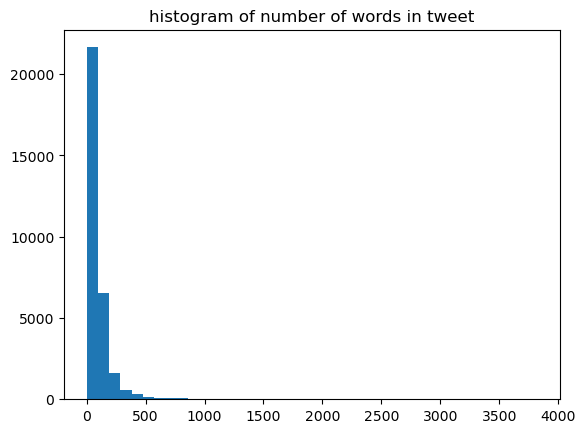

In [90]:
import matplotlib.pyplot as plt
plt.hist(reddit_data['text7_clean'].apply(lambda x:x.split(' ')).apply(len), bins=40)
plt.title('histogram of number of words in tweet')

In [91]:
# keep tweets which length is between 5 and 60 words
def drop_by_length(text, low, high):
  l = len(text.split(' '))
  if (l>=low) and (l<=high):
    return True
  else:
    return False

In [92]:
reddit_data=reddit_data[reddit_data['text_clean'].apply(lambda x: drop_by_length(x,7,1000))]

In [93]:
def remove_white_space(text):
    return " ".join(text.split())

In [94]:
reddit_data['text_clean']=reddit_data['text_clean'].apply(lambda x: remove_white_space(x))

/var/folders/vp/8_rd4_c56g3dpqb1167z6tqr0000gn/T/ipykernel_35684/364075501.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reddit_data['text_clean']=reddit_data['text_clean'].apply(lambda x: remove_white_space(x))


In [95]:
reddit_data=reddit_data.drop_duplicates(subset='text_clean').reset_index(drop=True)

In [96]:
print(len(reddit_data))

29023


### Text Sentiment Analysis

In [97]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tqdm import tnrange, tqdm_notebook, tqdm

In [98]:
analyzer = SentimentIntensityAnalyzer()
compound = []
for i,s in enumerate(tqdm(reddit_data['text_clean'],position=0, leave=True)):
    # print(i,s)
    vs = analyzer.polarity_scores(str(s))
    compound.append(vs["compound"])
reddit_data["compound"] = compound


100%|██████████| 29023/29023 [00:29<00:00, 979.35it/s] 


In [99]:
reddit_data

,upvote_ratio,score,total_awards_received,num_comments,selftext,datetime,text_clean,compound
0,0.33,0,0,14,"I recently caught a red herring, and you can d...",2022-01-01 00:00,recently caught red herring xb download intro ...,0.6124
1,0.24,0,0,22,I noticed that almost everyone in the crypto c...,2022-01-01 00:00,noticed almost everyone crypto community talk ...,0.9136
2,1.00,13,0,41,My records show I still had some BCHA on my Me...,2022-01-01 02:00,record show still bcha memo member wallet tryi...,0.2263
3,0.73,24,0,188,Merry Christmas and a Happy New Year. \n\nPS: ...,2022-01-01 05:00,merry christmas happy new year postscript try ...,0.8020
4,0.33,0,0,7,If you look at Bitcoin satoshies! There's $2....,2022-01-01 07:00,look bitcoin satoshies b btc satoshi one btc s...,0.4404
...,...,...,...,...,...,...,...,...
29018,0.80,154,1,64,[A HOUSE!](https://imgur.com/a/AklRmxT) I jus...,2022-06-30 20:00,house closed house finally achieved dream owni...,0.9492
29019,0.85,267,0,176,\> [BlockFi previously had a valuation of 4 bi...,2022-06-30 21:00,blockfi previously valuation billion raised mi...,0.4404
29020,0.78,5,0,40,"If you plan on never selling (and I mean it), ...",2022-06-30 22:00,plan never selling mean benefit choosing hardw...,-0.3570
29021,0.71,3,0,31,Was talking to a friend today trying to get hi...,2022-06-30 22:00,talking friend today trying get buy btc asked ...,0.2263


#### Textblob

In [100]:
# Textblob
from textblob import TextBlob

# create a function to get subjectivity
def getSubjectivity(twt):
    return TextBlob(twt).sentiment.subjectivity

# create a function to get the polarity
def getPolarity(twt):
    return TextBlob(twt).sentiment.polarity

In [101]:
# create two new columns called "Subjectivity" & "Polarity"
reddit_data['subjectivity'] = reddit_data['text_clean'].apply(getSubjectivity)
reddit_data['polarity'] = reddit_data['text_clean'].apply(getPolarity)

In [102]:
reddit_data

,upvote_ratio,score,total_awards_received,num_comments,selftext,datetime,text_clean,compound,subjectivity,polarity
0,0.33,0,0,14,"I recently caught a red herring, and you can d...",2022-01-01 00:00,recently caught red herring xb download intro ...,0.6124,0.352686,0.012397
1,0.24,0,0,22,I noticed that almost everyone in the crypto c...,2022-01-01 00:00,noticed almost everyone crypto community talk ...,0.9136,0.444444,-0.143750
2,1.00,13,0,41,My records show I still had some BCHA on my Me...,2022-01-01 02:00,record show still bcha memo member wallet tryi...,0.2263,0.473333,0.160000
3,0.73,24,0,188,Merry Christmas and a Happy New Year. \n\nPS: ...,2022-01-01 05:00,merry christmas happy new year postscript try ...,0.8020,0.613636,0.234091
4,0.33,0,0,7,If you look at Bitcoin satoshies! There's $2....,2022-01-01 07:00,look bitcoin satoshies b btc satoshi one btc s...,0.4404,0.650000,0.400000
...,...,...,...,...,...,...,...,...,...,...
29018,0.80,154,1,64,[A HOUSE!](https://imgur.com/a/AklRmxT) I jus...,2022-06-30 20:00,house closed house finally achieved dream owni...,0.9492,0.500733,0.157900
29019,0.85,267,0,176,\> [BlockFi previously had a valuation of 4 bi...,2022-06-30 21:00,blockfi previously valuation billion raised mi...,0.4404,0.083333,-0.083333
29020,0.78,5,0,40,"If you plan on never selling (and I mean it), ...",2022-06-30 22:00,plan never selling mean benefit choosing hardw...,-0.3570,0.687500,-0.312500
29021,0.71,3,0,31,Was talking to a friend today trying to get hi...,2022-06-30 22:00,talking friend today trying get buy btc asked ...,0.2263,0.200000,0.200000


#### Pysentiment2

In [103]:
import pysentiment2 as ps

In [104]:
sen=ps.LM()
def get_sentiment_score(text):
    tokens = sen.tokenize(text)
    score = sen.get_score(tokens)
    sum_score=score['Positive']+score['Negative']
    if sum_score==0:
        sum_score=1
    final_score=(score['Positive']-score['Negative'])/sum_score
    return final_score

In [105]:
reddit_data['pysenti_score'] = reddit_data['text_clean'].apply(get_sentiment_score)

In [106]:
reddit_data

,upvote_ratio,score,total_awards_received,num_comments,selftext,datetime,text_clean,compound,subjectivity,polarity,pysenti_score
0,0.33,0,0,14,"I recently caught a red herring, and you can d...",2022-01-01 00:00,recently caught red herring xb download intro ...,0.6124,0.352686,0.012397,1.000000
1,0.24,0,0,22,I noticed that almost everyone in the crypto c...,2022-01-01 00:00,noticed almost everyone crypto community talk ...,0.9136,0.444444,-0.143750,-0.142857
2,1.00,13,0,41,My records show I still had some BCHA on my Me...,2022-01-01 02:00,record show still bcha memo member wallet tryi...,0.2263,0.473333,0.160000,0.000000
3,0.73,24,0,188,Merry Christmas and a Happy New Year. \n\nPS: ...,2022-01-01 05:00,merry christmas happy new year postscript try ...,0.8020,0.613636,0.234091,1.000000
4,0.33,0,0,7,If you look at Bitcoin satoshies! There's $2....,2022-01-01 07:00,look bitcoin satoshies b btc satoshi one btc s...,0.4404,0.650000,0.400000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
29018,0.80,154,1,64,[A HOUSE!](https://imgur.com/a/AklRmxT) I jus...,2022-06-30 20:00,house closed house finally achieved dream owni...,0.9492,0.500733,0.157900,0.333333
29019,0.85,267,0,176,\> [BlockFi previously had a valuation of 4 bi...,2022-06-30 21:00,blockfi previously valuation billion raised mi...,0.4404,0.083333,-0.083333,0.000000
29020,0.78,5,0,40,"If you plan on never selling (and I mean it), ...",2022-06-30 22:00,plan never selling mean benefit choosing hardw...,-0.3570,0.687500,-0.312500,1.000000
29021,0.71,3,0,31,Was talking to a friend today trying to get hi...,2022-06-30 22:00,talking friend today trying get buy btc asked ...,0.2263,0.200000,0.200000,-1.000000


### Do not remove the neutral score

In [107]:
reddit_score= pd.DataFrame(columns=['datetime','compound','polarity','subjectivity'])
# reddit_data['datetime']=pd.to_datetime(reddit_data['datetime'])
# Grouping by datetime and calculating mean sentiment score
compound_grouped_data = reddit_data.groupby('datetime').apply(lambda x: (x['compound']*x['upvote_ratio']).sum()/(x['upvote_ratio']).sum())
reddit_score['compound']=compound_grouped_data

polarity_data=reddit_data.groupby('datetime')['polarity'].mean()
subjectivity_data=reddit_data.groupby('datetime')['subjectivity'].mean()

reddit_score['polarity']=polarity_data
reddit_score['subjectivity']=subjectivity_data

In [108]:
reddit_score.drop(columns=['datetime'], inplace=True)

In [109]:
reddit_score

,compound,polarity,subjectivity
datetime,,,
2022-01-01 00:00,0.806147,0.106285,0.464971
2022-01-01 01:00,0.523754,0.165466,0.469433
2022-01-01 02:00,0.404721,-0.003025,0.499500
2022-01-01 03:00,0.307653,0.129557,0.461581
2022-01-01 04:00,0.682042,0.108311,0.422146
...,...,...,...
2022-06-30 19:00,0.537786,0.112709,0.459895
2022-06-30 20:00,0.456615,0.075858,0.494026
2022-06-30 21:00,0.786424,0.053945,0.433892


### Remove the neutral score

In [110]:
reddit_data_filter=reddit_data[reddit_data['compound'] != 0]

In [111]:
filter_reddit_score= pd.DataFrame(columns=['datetime','compound','polarity','subjectivity'])
# reddit_data_filter['datetime']=pd.to_datetime(reddit_data_filter['datetime'])
# Grouping by datetime and calculating mean sentiment score
compound_grouped_data = reddit_data_filter.groupby('datetime').apply(lambda x: (x['compound']*x['upvote_ratio']).sum()/(x['upvote_ratio']).sum())
filter_reddit_score['compound']=compound_grouped_data

polarity_data=reddit_data_filter.groupby('datetime')['polarity'].mean()
subjectivity_data=reddit_data_filter.groupby('datetime')['subjectivity'].mean()

filter_reddit_score['polarity']=polarity_data
filter_reddit_score['subjectivity']=subjectivity_data

In [112]:
filter_reddit_score.drop(columns=['datetime'], inplace=True)

In [113]:
filter_reddit_score

,compound,polarity,subjectivity
datetime,,,
2022-01-01 00:00,0.865422,0.097302,0.473199
2022-01-01 01:00,0.523754,0.165466,0.469433
2022-01-01 02:00,0.404721,-0.003025,0.499500
2022-01-01 03:00,0.307653,0.129557,0.461581
2022-01-01 04:00,0.682042,0.108311,0.422146
...,...,...,...
2022-06-30 19:00,0.537786,0.112709,0.459895
2022-06-30 20:00,0.456615,0.075858,0.494026
2022-06-30 21:00,0.786424,0.053945,0.433892


In [114]:
reddit_score.to_csv('./data/Reddit/reddit_score.csv')

In [115]:
filter_reddit_score.to_csv('./data/Reddit/filter_reddit_score.csv')

## Reddit posts without weight

In [116]:
reddit_score= pd.DataFrame(columns=['datetime','compound','polarity','subjectivity'])
# reddit_data['datetime']=pd.to_datetime(reddit_data['datetime'])
# Grouping by datetime and calculating mean sentiment score
compound_grouped_data = reddit_data.groupby('datetime')['compound'].mean()
reddit_score['compound']=compound_grouped_data

polarity_data=reddit_data.groupby('datetime')['polarity'].mean()
subjectivity_data=reddit_data.groupby('datetime')['subjectivity'].mean()

reddit_score['polarity']=polarity_data
reddit_score['subjectivity']=subjectivity_data

In [117]:
reddit_score.to_csv('./data/Reddit/without_weight_reddit_score.csv')